# Solving the Schroedinger Equations Using the Finite Difference Itme Domain Method

10.1088/1751-8113/40/8/013

In [1]:
import dataclasses
import math

import numpy as np

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from tqdm import tqdm

In [2]:
@dataclasses.dataclass(frozen=True)
class Boundary:
    start: float
    end: float
    step: float

In [3]:
class DirichletSystem:
    def __init__(self, pot, time_dom, spatial_doms, bd_cond=None, max_iter=None, stop_tol=1.0e-5, prior_vecs=None, **kwargs) -> None:
        self.pbc = False
        if prior_vecs is None:
            self.priors = []
        else:
            self.priors = list(prior_vecs)
        self.pot = pot
        # 0: time, 1: X, 2: Y, 3: Z
        self.time_dom = time_dom
        self.spat_dom = list(spatial_doms)
        self.vol = np.prod([dom.step for dom in self.spat_dom])
        self.time_len = int((time_dom.end - time_dom.start) / time_dom.step) + 1
        self._init_mesh()
        # self._initialize()
        self.bd_cond = bd_cond
        self.counter = 0
        self.stop_tol = stop_tol
        self.max_iter = max_iter
        self.logs = []
    
    def _init_mesh(self):
        self.spaces = [np.linspace(dom.start, dom.end, int((dom.end - dom.start) / dom.step) + 1) for dom in self.spat_dom]
        space_meshs = [x for x in np.meshgrid(*self.spaces, indexing='ij')]
        print(space_meshs[0].shape)
        self.sol_mesh = np.zeros([self.time_len, *space_meshs[0].shape])
        self.sol_shape = tuple(space_meshs[0].shape)
        self.space_meshs = np.asarray([x.flatten() for x in space_meshs])
        self.ndim = len(self.sol_shape)

    def normalize(self, psi):
        nn = np.sqrt(np.sum(psi * psi) * self.vol)
        nn = 1.0 / nn
        out = psi * nn
        return out

    def _initialize(self, psi0_grid):
#         self.sol_mesh[0] = self.normalize(psi0_grid)
        self.sol_mesh[0] = psi0_grid
        self._apply_boundary(0)

        pot_grid = np.zeros(np.prod(self.sol_shape))
        for i, xi in enumerate(zip(*self.space_meshs)):
            pot_grid[i] = self.pot(*xi)
        self.pot_grid = pot_grid.reshape(self.sol_shape)

    def set_psi0_by_func(self, func):
        psi0_grid = np.zeros(np.prod(self.sol_shape))
        for i, xi in enumerate(zip(*self.space_meshs)):
            psi0_grid[i] = func(*xi)
        psi0_grid = psi0_grid.reshape(self.sol_shape)
        self._initialize(psi0_grid)

    def set_psi0_by_grid(self, psi0_grid):
        self._initialize(psi0_grid)

    def _apply_boundary(self, n):
        if (self.bd_cond is None) and (self.pbc == False):
            sx = slice(None, None, None)
            for i, l in enumerate(self.sol_shape):
                ind = tuple([0 if i == j else sx for j in range(self.ndim)])
                self.sol_mesh[n][ind] = 0.0
                ind = tuple([l - 1 if i == j else sx for j in range(self.ndim)])
                self.sol_mesh[n][ind] = 0.0
                
    def _prepare(self, n=0, *args, **kwargs):
        psi = self.sol_mesh[n]
        for vec in self.priors:
            inner = np.sum(psi * self.normalize(vec) * self.vol)
            self.sol_mesh[n] -= inner * vec

    def solve(self):
        dt = self.time_dom.step
        self.energy_series = np.zeros(self.time_len)
        sx = slice(None, None, None)

        beta = 1.0 / (1.0 + 0.5 * dt * self.pot_grid)
        alpha = (1.0 - 0.5 * dt * self.pot_grid) * beta
        self._prepare()
        
        if self.max_iter is not None and self.max_iter < self.time_len:
            t_len = self.max_iter
        else:
            t_len = self.time_len
    
        for n in tqdm(range(0, t_len)):
            self.counter = n
            kine = np.zeros(self.sol_shape)
            px = self.sol_mesh[n]

            self._prepare(n=n)
            
            for i in range(self.ndim):
                if self.pbc:
                    ind0 = tuple([0 if i == j else sx for j in range(self.ndim)])
                    ind1 = tuple([1 if i == j else sx for j in range(self.ndim)])
                    ind2 = tuple([-1 if i == j else sx for j in range(self.ndim)])
                    ind3 = tuple([-2 if i == j else sx for j in range(self.ndim)])
                    
                    px[ind2] = px[ind0] + (1/3) * px[ind3] - (1/3) * px[ind1]
                
                ind1 = tuple([slice(1, -1, None) if i == j else sx for j in range(self.ndim)])
                ind2 = tuple([slice(0, -2, None) if i == j else sx for j in range(self.ndim)])
                ind3 = tuple([slice(2, None, None) if i == j else sx for j in range(self.ndim)])

                term = px[ind2] + px[ind3] - 2.0 * px[ind1]

                if self.pbc:
                    ind0 = tuple([0 if i == j else sx for j in range(self.ndim)])
                    ind1 = tuple([1 if i == j else sx for j in range(self.ndim)])
                    ind2 = tuple([-1 if i == j else sx for j in range(self.ndim)])
                    ind3 = tuple([-2 if i == j else sx for j in range(self.ndim)])
                    
                    term += px[ind3]
                    term += px[ind1]
                    term -= px[ind0]
                    term -= px[ind2]
                
                ind1 = tuple([slice(1, -1, None) if i == j else sx for j in range(self.ndim)])
                term /= (2.0 * self.spat_dom[i].step ** 2)
                kine[ind1] += term

            energy_before = np.sum(self.pot_grid * px * px) - (kine * px).sum()
            energy_before /= (px * px).sum()

            self.energy_series[n] = energy_before # * self.vol ** 2
            
            if n + 1 < self.time_len:
                self.sol_mesh[n + 1] = alpha * self.sol_mesh[n]
                self.sol_mesh[n + 1] += dt * beta * kine
                # self._apply_boundary(n + 1)
                
                psi = self.sol_mesh[n + 1]
                nn2 = np.sum(psi * psi) * self.vol
                self.logs.append(np.sqrt(nn2))
                
                self.sol_mesh[n + 1] = self.normalize(self.sol_mesh[n + 1])

            # if n > 0 and self.stop_tol is not None:
            #     error = np.abs(1 - self.energy_series[n - 1] / energy_before)
            #     if error < self.stop_tol:
            #         break

    def get_solution(self):
        return self.spaces, self.sol_mesh[self.counter]
    
    def get_full_mesh(self):
        return self.spaces, self.sol_mesh

    def get_energy(self):
        return self.energy_series

In [4]:
def draw_energies(ex):
    fig1, ax1 = plt.subplots()
    y1 = np.ones_like(ex[0]) * np.pi**2/2*1
    y2 = np.ones_like(ex[0]) * np.pi**2/2*4
    y3 = np.ones_like(ex[0]) * np.pi**2/2*9
    y4 = np.ones_like(ex[0]) * np.pi**2/2*16
    ax1.plot(y1, label="$\pi^{2}/2$")
    ax1.plot(y2, label="$4\pi^{2}/2$")
    ax1.plot(y3, label="$9\pi^{2}/2$")
    ax1.plot(y4, label="$16\pi^{2}/2$")
    for i,ee in enumerate(ex):
        ax1.plot(ee, label=f"{i+1}th Energy")
    ax1.grid()
    ax1.set_ylim(0, 150.0)
    fig1.legend()
    ax1.set_title("1d Free particle")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Energy")
    fig1.savefig('1d-free.png', dpi=300)
    plt.show(fig1)

In [5]:
x0, x1, dx = 0.0, 1.0, 0.01
t0, t1, dt = 0.0, 1.0, dx*dx*0.2

dom_t = Boundary(t0, t1, dt)
dom_x = Boundary(x0, x1, dx)

def pot(mesh):
    return np.zeros_like(mesh)
    # return mesh*mesh*100

def init1(x):
    return np.random.randn(1)

def init2(x):
    return np.random.rand() * 2 - 1

sys1 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=[dom_x], stop_tol=1.0e-7, max_iter=None)
psi0 = np.random.randn(*sys1.sol_shape)
sys1.set_psi0_by_grid(psi0)
# sys1.set_psi0_by_func(init1)
sys1.solve()

# draw_energies([sys1.get_energy()])
_, u = sys1.get_solution()
v1 = u.copy()

sys2 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=[dom_x], prior_vecs=[v1], stop_tol=1.0e-7, max_iter=None)
sys2.set_psi0_by_grid(psi0)
# sys2.set_psi0_by_func(init1)
sys2.solve()

# draw_energies([sys2.get_energy()])
_, u = sys2.get_solution()
v2 = u.copy()

sys3 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=[dom_x], prior_vecs=[v1, v2], stop_tol=1.0e-7, max_iter=None)
sys3.set_psi0_by_grid(psi0)
sys3.solve()

# draw_energies([sys3.get_energy()])
_, u = sys3.get_solution()
v3 = u.copy()

sys4 = DirichletSystem(pot=pot, time_dom=dom_t, spatial_doms=[dom_x], prior_vecs=[v1, v2, v3], stop_tol=1.0e-7, max_iter=None)
sys4.set_psi0_by_grid(psi0)
sys4.solve()

# draw_energies([sys4.get_energy()])
_, u = sys4.get_solution()
v4 = u.copy()



(101,)


100%|██████████| 50000/50000 [00:02<00:00, 18628.71it/s]


(101,)


100%|██████████| 50000/50000 [00:03<00:00, 13519.11it/s]


(101,)


100%|██████████| 50000/50000 [00:04<00:00, 10912.13it/s]


(101,)


100%|██████████| 50000/50000 [00:05<00:00, 9049.45it/s]


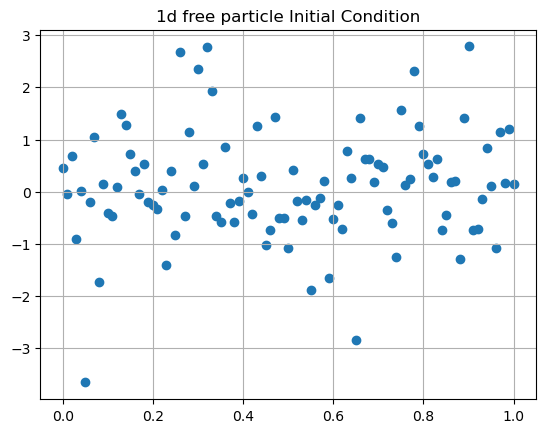

In [6]:
plt.scatter(sys1.spaces,psi0)
plt.title("1d free particle Initial Condition")
plt.grid()
plt.savefig('1d-free init.png', dpi=300)
plt.show()

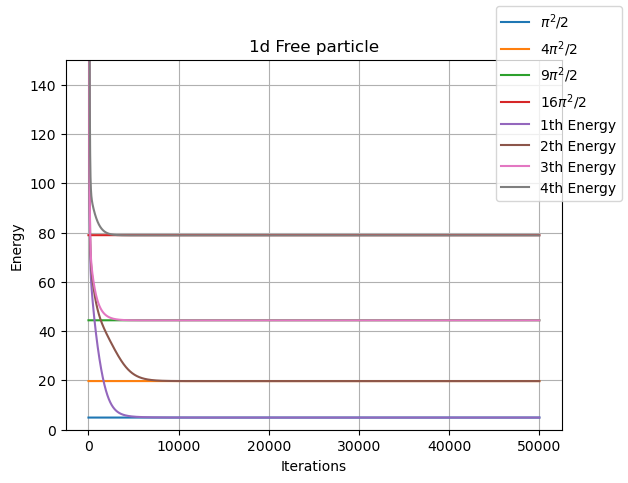

In [7]:
energy = [sys1.get_energy(),sys2.get_energy(), sys3.get_energy(), sys4.get_energy()]
draw_energies(energy)

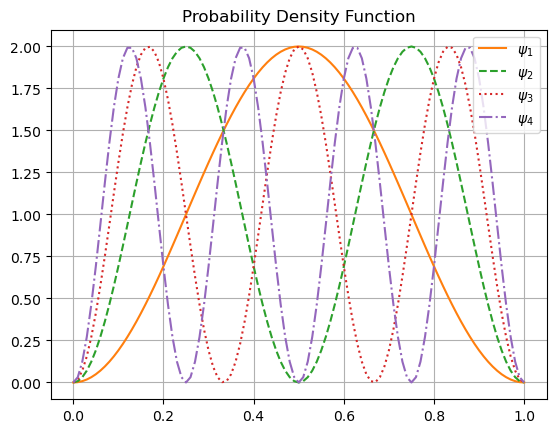

In [8]:
X, v1= sys1.get_solution()
_, v2= sys2.get_solution()
_, v3= sys3.get_solution()
_, v4= sys4.get_solution()


# draw_energies([energies])

fig2, ax2 = plt.subplots()
skip = 1
ax2.plot(X[0][::skip], v1[::skip] ** 2, 'C1-', label='$\psi_1$')
ax2.plot(X[0][::skip], v2[::skip] ** 2, 'C2--', label='$\psi_2$')
ax2.plot(X[0][::skip], v3[::skip] ** 2, 'C3:', label='$\psi_3$')
ax2.plot(X[0][::skip], v4[::skip] ** 2, 'C4-.', label='$\psi_4$')
# ax2.plot(X[0][::skip], U[1, ::skip] ** 2, 'gx')
# ax2.plot(X[0], 2.0 * np.sin(X[0] * np.pi) **2, 'g-', lw=2, label='$\phi$')
ax2.set_title("Probability Density Function")
ax2.legend()
ax2.grid()
fig2.savefig('1d-free pdf.png', dpi=300)
plt.show(fig2)

In [9]:
np.save("groud.npy", v1)
np.save("first.npy", v2)
np.save("second.npy", v3)
np.save("third.npy",v4)
np.save("ground energy.npy", sys1.get_energy())
np.save("first energy.npy", sys2.get_energy())
np.save("second energy.npy", sys3.get_energy())
np.save("third energy.npy", sys4.get_energy())
np.save("initial.npy", psi0)